# Import Packages

In [1]:
import sys
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import pandas as pd
import math
import matplotlib.pyplot as plt

!{sys.executable} -m pip install pokebase
import pokebase as pb 

You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Part 1: Data Collection and Cleaning

## Fetch and Clean Smogon Usage Data

In [2]:
data = urlopen("https://www.smogon.com/stats/2019-03/gen7ubers-0.txt")
usage = []
for line in data:
    decoded = line.decode('utf-8')
    decoded = decoded.replace(" ", "")
    if decoded.startswith('|'):
        # usage - weighted based on matchmaking rating
        # raw - unweighted usage (on team)
        # real - actually used in battle
        decodedList = decoded.split('|')[1:-1]
        decodedList.pop(2) # remove usage %
        decodedList.pop() # remove real
        decodedList.pop() # remove real %
        usage.append(decodedList)
smogon_df = pd.DataFrame(usage[1:], columns=usage[0])
smogon_df

,Rank,Pokemon,Raw,%
0,1,Groudon-Primal,274400,39.068%
1,2,Xerneas,198831,28.309%
2,3,Necrozma-Dusk-Mane,149044,21.220%
3,4,Yveltal,147205,20.959%
4,5,Kyogre-Primal,145560,20.724%
5,6,Marshadow,144160,20.525%
6,7,Arceus,85301,12.145%
7,8,Zygarde,71765,10.218%
8,9,Lugia,69956,9.960%
9,10,Aegislash,68805,9.796%


The specific usage statistic we are interested is called "raw [usage]", as we do not want to weigh by a player's skill. In addition, a Pokemon merely appearing on a team means a player has made the decision to reserve a valuable team spot for a Pokemon. The "usage" and "real" columns have been dropped to make data manipulation easier.

From now on, "raw" and "usage" both refer to the this raw statistic.

## Obtain list of legendary and mystical Pokémon from Bulbapedia

In [3]:
# scrape list of legendary and mystical pokemon from bulbapedia
page = requests.get("https://bulbapedia.bulbagarden.net/wiki/Legendary_Pok%C3%A9mon")
soup = BeautifulSoup(page.content, 'html.parser')

# list of <a> tags of legendary pokemon
a_list = soup.select('td[style*="background: #e6e6ff"] a')

# extract text from <a> tags
legend_list = [lp.get_text() for lp in a_list]

# data cleaning: replace whitespace with hyphen, remove colon
legend_list = [p.lower().replace(' ', '-').replace(':', '') for p in legend_list]
legend_list_smogon = legend_list.copy()
legend_list

['articuno',
 'zapdos',
 'moltres',
 'mewtwo',
 'mew',
 'raikou',
 'entei',
 'suicune',
 'lugia',
 'ho-oh',
 'celebi',
 'regirock',
 'regice',
 'registeel',
 'latias',
 'latios',
 'kyogre',
 'groudon',
 'rayquaza',
 'jirachi',
 'deoxys',
 'uxie',
 'mesprit',
 'azelf',
 'dialga',
 'palkia',
 'heatran',
 'regigigas',
 'giratina',
 'cresselia',
 'phione',
 'manaphy',
 'darkrai',
 'shaymin',
 'arceus',
 'victini',
 'cobalion',
 'terrakion',
 'virizion',
 'tornadus',
 'thundurus',
 'reshiram',
 'zekrom',
 'landorus',
 'kyurem',
 'keldeo',
 'meloetta',
 'genesect',
 'xerneas',
 'yveltal',
 'zygarde',
 'diancie',
 'hoopa',
 'volcanion',
 'type-null',
 'silvally',
 'tapu-koko',
 'tapu-lele',
 'tapu-bulu',
 'tapu-fini',
 'cosmog',
 'cosmoem',
 'solgaleo',
 'lunala',
 'necrozma',
 'magearna',
 'marshadow',
 'zeraora',
 'meltan',
 'melmetal',
 'zacian',
 'zamazenta']

Bulbapedia is a community-driven resource about Pokemon and is one of the biggest Pokemon resources in the community. We use their page on legendary Pokemon to for a list of legendary Pokemon to classify our data.

## After scraping and cleaning, test legendary name validity by searching for each name in the API

In [4]:
for p in legend_list:
    try:
        pb.pokemon(p)
    except ValueError:
        print("Cannot find", p)

Cannot find deoxys
Cannot find giratina
Cannot find shaymin
Cannot find tornadus
Cannot find thundurus
Cannot find landorus
Cannot find keldeo
Cannot find meloetta
Cannot find meltan
Cannot find melmetal
Cannot find zacian
Cannot find zamazenta


## The above Pokémon have alternate forms and we must handle each manually

P.S. Meltan and Melmetal, mythical Pokémon introduced in Gen VII, haven't been added to the database at the moment. https://github.com/PokeAPI/pokeapi/issues/414

P.S. Zacian and Zamazenta, new legendary Pokémon introduced in Gen VIII, haven't been added to the database at the moment.  

In [5]:
# deoxys: deoxys-normal, deoxys-attack, deoxys-defense, deoxys-speed
try:
    legend_list.remove('deoxys')
    legend_list.extend(['deoxys-normal', 'deoxys-attack', 'deoxys-defense', 'deoxys-speed'])
except ValueError:
    print('Error')

# giratina: giratina-altered, giratina-origin
try:
    legend_list.remove('giratina')
    legend_list.extend(['giratina-altered', 'giratina-origin'])
except ValueError:
    print('Error')

# shaymin: shaymin-land, shaymin-sky
try:
    legend_list.remove('shaymin')
    legend_list.extend(['shaymin-land', 'shaymin-sky'])
except ValueError:
    print('Error')

# tornadus: tornadus-incarnate, tornadus-therian
try:
    legend_list.remove('tornadus')
    legend_list.extend(['tornadus-incarnate', 'tornadus-therian'])
except ValueError:
    print('Error')

# thundurus: thundurus-incarnate, thundurus-therian
try:
    legend_list.remove('thundurus')
    legend_list.extend(['thundurus-incarnate', 'thundurus-therian'])
except ValueError:
    print('Error')

# landorus: landorus-incarnate, landorus-therian
try:
    legend_list.remove('landorus')
    legend_list.extend(['landorus-incarnate', 'landorus-therian'])
except ValueError:
    print('Error')

# keldeo: keldeo-ordinary, keldeo-resolute
try:
    legend_list.remove('keldeo')
    legend_list.extend(['keldeo-ordinary', 'keldeo-resolute'])
except ValueError:
    print('Error')

# meloetta: meloetta-aria, meloetta-pirouette
try:
    legend_list.remove('meloetta')
    legend_list.extend(['meloetta-aria', 'meloetta-pirouette'])
except ValueError:
    print('Error')

# meltan: remove for now
try:
    legend_list.remove('meltan')
except ValueError:
    print('Error')

# melmetal: remove for now
try:
    legend_list.remove('melmetal')
except ValueError:
    print('Error')
    
# zacian: remove for now
try:
    legend_list.remove('zacian')
except ValueError:
    print('Error')

# zamazenta: remove for now
try:
    legend_list.remove('zamazenta')
except ValueError:
    print('Error')

## Test again for validity

In [6]:
for p in legend_list:
    try:
        pb.pokemon(p)
    except ValueError:
        print("Cannot find", p)

## Get CSV file for all Pokémon info

In [7]:
# #Only run if you need the DF in the code itself, the cell above should retrieve the file
# import re
# pokemonList = []
# pokemonList.append(['ID', 'Pokemon', 'Legendary', 'Stat Total', 'ATK Sum', 'DEF Sum', 'Height', 'Weight', 'Type 1', 'Type 2'])

# for pokemonID in range(1,808):
#   pokemon_stats = []
#   pokemon_info = pb.pokemon(pokemonID)
  
#   pokemon_stats.append(pokemonID) # Add ID
#   pokemon_stats.append(pokemon_info.name) # Add Name
#   pokemon_stats.append(pokemon_info.name in legend_list) # Add Legendary or Not
#   pokemon_stats.extend([0,0,0]) # Add categories for stat totals
#   pokemon_stats.append(pokemon_info.height) # Add Height
#   pokemon_stats.append(pokemon_info.weight) # Add Weight

#   print(pokemonID)
#   j = 0 # Counter because I didnt want to change my code anymore
#   for i in (pokemon_info.stats):
#     stringStats = str(i)
#     value = [int(s) for s in re.findall(r'\b\d+\b', stringStats)[:1]]
#     pokemon_stats[3] += value[0]
#     pokemon_stats[4+(j%2)] += value[0]
#     j += 1
   
#   for i in pokemon_info.types:
#     stringType = str(i)
#     typing = re.findall('\'name\': \'(.+?)\'', stringType)
#     pokemon_stats.append(typing[0])
    
    
#   if len(pokemon_info.types) == 1:
#     pokemon_stats.append("N/A")
    
#   pokemonList.append(pokemon_stats)

# statsDF = pd.DataFrame(pokemonList[1:], columns=pokemonList[0])
# statsDF.to_csv ('./statsDF.csv', index = None, header=True)

# statsDF

In [8]:
df = pd.read_csv('statsDF.csv')
df

,ID,Pokemon,Legendary,Stat Total,ATK Sum,DEF Sum,Height,Weight,Type 1,Type 2
0,1,bulbasaur,False,318,159,159,7,69,poison,grass
1,2,ivysaur,False,405,202,203,10,130,poison,grass
2,3,venusaur,False,525,262,263,20,1000,poison,grass
3,4,charmander,False,309,177,132,6,85,fire,NaN
4,5,charmeleon,False,405,224,181,11,190,fire,NaN
5,6,charizard,False,534,293,241,17,905,flying,fire
6,7,squirtle,False,314,141,173,5,90,water,NaN
7,8,wartortle,False,405,186,219,10,225,water,NaN
8,9,blastoise,False,530,246,284,16,855,water,NaN
9,10,caterpie,False,195,95,100,3,29,bug,NaN


## Obtain list of Pokémon types

In [9]:
# scrape list of pokemon types from bulbapedia
page = requests.get("https://bulbapedia.bulbagarden.net/wiki/Type")
soup = BeautifulSoup(page.content, 'html.parser')

# list of <a> tags of types
a_list = soup.select('td a[title*="(type)"]')

# extract text from <a> tags
type_list = [lp.get_text() for lp in a_list]

# ignore ??? type
type_list = type_list[:-1]
type_list

['Normal',
 'Fire',
 'Fighting',
 'Water',
 'Flying',
 'Grass',
 'Poison',
 'Electric',
 'Ground',
 'Psychic',
 'Rock',
 'Ice',
 'Bug',
 'Dragon',
 'Ghost',
 'Dark',
 'Steel',
 'Fairy']

## Match legendary list to Smogon names

In [10]:
legend_list_smogon.extend(['deoxys-attack', 'deoxys-defense', 'deoxys-speed'])
legend_list_smogon.extend(['giratina-origin'])
legend_list_smogon.extend(['shaymin-sky'])
legend_list_smogon.extend(['tornadus-therian'])
legend_list_smogon.extend(['thundurus-therian'])
legend_list_smogon.extend(['landorus-therian'])

try:
    legend_list_smogon.remove('meltan')
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('melmetal')
except ValueError:
    print('Error')

# smogon pokemon names are captialized
legend_list_smogon = [str.title(name) for name in legend_list_smogon]

try:
    legend_list_smogon.remove('Tapu-Koko')
    legend_list_smogon.extend(['TapuKoko'])
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('Tapu-Lele')
    legend_list_smogon.extend(['TapuLele'])
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('Tapu-Bulu')
    legend_list_smogon.extend(['TapuBulu'])
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('Tapu-Fini')
    legend_list_smogon.extend(['TapuFini'])
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('Type-Null')
    legend_list_smogon.extend(['Type:Null'])
except ValueError:
    print('Error')

Smogon's name formatting is somewhat different than the format we use elsewhere in this notebook. We are doing some manual editing for entries that differ to match the naming used by Smogon.

# Part 2: Smogon Competitive Usage Data Analysis

## Visualizing Smogon Usage Data

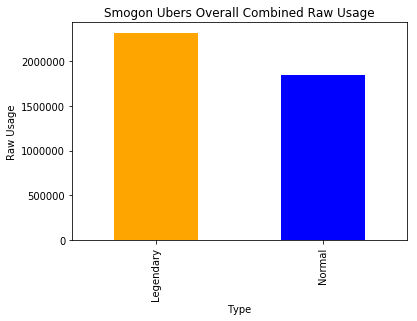

,Type,Raw Usage
0,Legendary,2319636
1,Normal,1848922


In [11]:
# convert string to number
smogon_df['Raw'] = smogon_df['Raw'].astype(int)

# using legend_list_smogon, split dataframe
smogon_legend_df = smogon_df[smogon_df['Pokemon'].str.contains('|'.join(legend_list_smogon))].copy()
smogon_legend_df['Rank'] = smogon_legend_df['Rank'].astype(int)
smogon_normal_df = smogon_df[-smogon_df['Pokemon'].str.contains('|'.join(legend_list_smogon))].copy()
smogon_normal_df['Rank'] = smogon_normal_df['Rank'].astype(int)

# plot raw usage of legendaries vs normal
smogon_usage_graph_data = [
  ['Legendary', smogon_legend_df['Raw'].sum()],
  ['Normal', smogon_normal_df['Raw'].sum()]
]
smogon_usage_graph_df = pd.DataFrame(smogon_usage_graph_data, columns = ['Type', 'Raw Usage'])
ax_smogon_usage = smogon_usage_graph_df.plot.bar(x = 'Type', y = 'Raw Usage', title = 'Smogon Ubers Overall Combined Raw Usage',
  legend = False, color = ['orange', 'blue'])
ax_smogon_usage.set_xlabel('Type')
ax_smogon_usage.set_ylabel('Raw Usage')
plt.show()
smogon_usage_graph_df

Comparing the overall combined raw usage of legendary against normal Pokemon, we can see that legendary Pokemon are somewhat more popular in team compositions by a difference of 22.58%. 

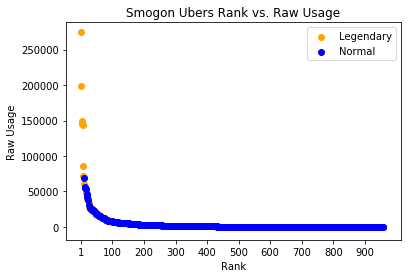

In [12]:
# plot raw usage against rank
plt.scatter(smogon_legend_df['Rank'], smogon_legend_df['Raw'], color = 'orange')
plt.scatter(smogon_normal_df['Rank'], smogon_normal_df['Raw'], color = 'blue')
plt.title('Smogon Ubers Rank vs. Raw Usage')
plt.xlabel('Rank')
plt.ylabel('Raw Usage')
plt.xticks([1, *range(100, len(smogon_df), 100)])
plt.legend(['Legendary', 'Normal'])
plt.show()

Here, we plot the raw usage of each Pokemon against their rank. It is apparent that only a certain amount of Pokemon are widely used, and the rest quickly fall off in usage. In addition, at first glance it would appear that legendary Pokemon seem to dominate the upper ranks. It is hard to tell for sure without a further breakdown since the dots overlap each other. 

In [13]:
print('Legendary:\n', smogon_legend_df['Raw'].describe(), '\n\nNormal:\n', smogon_normal_df['Raw'].describe())

Legendary:
 count       123.000000
mean      18858.829268
std       40850.295869
min          25.000000
25%         818.000000
50%        2900.000000
75%       17505.500000
max      274400.000000
Name: Raw, dtype: float64 

Normal:
 count      834.000000
mean      2216.932854
std       6011.370972
min          1.000000
25%         63.000000
50%        321.000000
75%       1701.750000
max      68805.000000
Name: Raw, dtype: float64


Looking at the statistics and graph of all legendary and normal Pokemon, our data is subject to extreme skew due to the amount of Pokemon that remain relatively unused. Thus, we will visualize the most used Pokemon to make it easier to analyze. We decided on the top 10% usage of all Pokemon, which rounds up to 96.

### Visualizing Just the Top 10%

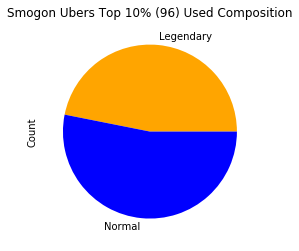

,Type,Count
0,Legendary,45
1,Normal,51


In [14]:
# get top x% used
smogon_top_count = math.ceil(len(smogon_df) * 0.1) # used for the cutoffs
smogon_legend_top_df = (smogon_legend_df[smogon_legend_df['Rank'] <= smogon_top_count])
smogon_normal_top_df = (smogon_normal_df[smogon_normal_df['Rank'] <= smogon_top_count])

smogon_num_legend_top = smogon_legend_top_df['Rank'].size
smogon_num_normal_top = smogon_normal_top_df['Rank'].size
smogon_num_graph_data = [
  ['Legendary', smogon_num_legend_top],
  ['Normal', smogon_num_normal_top]
]
smogon_num_graph_top_df = pd.DataFrame(smogon_num_graph_data, columns = ['Type', 'Count'])
ax_smogon_num_top = smogon_num_graph_top_df.plot.pie(x = 'Type', y = 'Count', title = 'Smogon Ubers Top 10% ({}) Used Composition'.format(smogon_top_count),
  legend = False, colors = ['orange', 'blue'], labels = ['Legendary', 'Normal'])
plt.show()
smogon_num_graph_top_df

In [15]:
print('Legendary in Top 10%:\n', smogon_legend_top_df['Raw'].describe(), \
      '\n\nNormal in Top 10%:\n', smogon_normal_top_df['Raw'].describe())

Legendary in Top 10%:
 count        45.000000
mean      48429.933333
std       56661.093534
min        8907.000000
25%       15831.000000
50%       23644.000000
75%       53916.000000
max      274400.000000
Name: Raw, dtype: float64 

Normal in Top 10%:
 count       51.000000
mean     20206.274510
std      14432.625164
min       8051.000000
25%       9928.000000
50%      15080.000000
75%      24082.500000
max      68805.000000
Name: Raw, dtype: float64


Looking at the statistcs of the top 10%, we can see this is somewhat more reasonable than analyzing them all. In the top 10%, there are more normal Pokemon than legendary Pokemon by a difference of 12.50%. However, the difference in usage is still quite large.

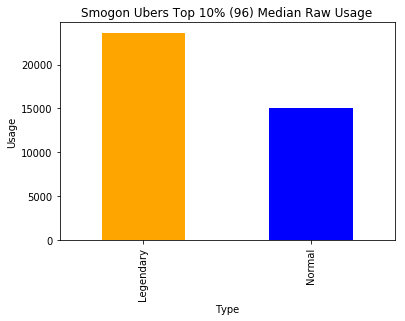

,Type,Usage
0,Legendary,23644.0
1,Normal,15080.0


In [16]:
# get the makeup of the top x% used
smogon_num_graph_data_usage = [
  ['Legendary', smogon_legend_top_df['Raw'].median()],
  ['Normal', smogon_normal_top_df['Raw'].median()]
]
smogon_usage_top_graph_df = pd.DataFrame(smogon_num_graph_data_usage, columns = ['Type', 'Usage'])
ax_smogon_usage_top = smogon_usage_top_graph_df.plot.bar(x = 'Type', y = 'Usage', title = 'Smogon Ubers Top 10% ({}) Median Raw Usage'.format(smogon_top_count),
  legend = False, color = ['orange', 'blue'])
ax_smogon_usage_top.set_xlabel('Type')
ax_smogon_usage_top.set_ylabel('Usage')
plt.show()
smogon_usage_top_graph_df

The medians have been graphed instead of the mean as the maximum legendary usage is quite large, and the median is more robust in this scenario. Looking at just the top 10% medians of raw usage, legendary Pokemon are still used far more than normal Pokemon by a difference of 50.84%.

## Analysis of Usage Results

The usage of legendary Pokemon compared to normal Pokemon is undoubtedly larger. This is especially true at the very top - the difference between the most used legendary Pokemon far surpass the normal Pokemon. With this usage difference, the fact that there are ten more normal Pokemon than legendary in the top 10% may be surprising. However, it is important to note that there are vastly more normal Pokemon than legendary. Smogon has 838 entries that are classified as normal, compared to 119 that are classified as legendary. With that many more normal Pokemon, there are bound to be quite a few normal Pokemon that can be considered a valuable addition to the team. Regardless, this large difference in usage between legendary and normal Pokemon is significant and must be due to some kind of attribute differences legendary Pokemon possess. In the next part, we will look at the objective data of legendary Pokemon against normal Pokemon.

# Part 3: Physical Attributes Analysis

## 3.1 Weight vs. Height

Using a scatter plots, we can examine the relationship between the height and weight of all Pokémon. The plots below show how most Pokémon's measurements concentrate toward the bottom left corner, whereas there are only a few outliers.

### Non-legendaries

[Text(0, 0.5, 'Height (decimetres)'), Text(0.5, 0, 'Weight (hectograms)')]

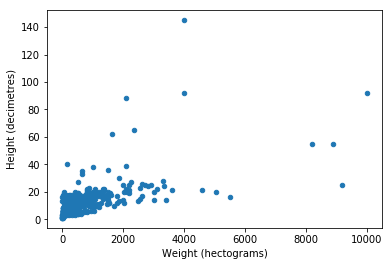

In [17]:
df[~df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot.scatter('Weight', 'Height').set(xlabel='Weight (hectograms)', ylabel='Height (decimetres)')

At first glance, we can see in the scatter plot that the bulk of Non-Legendary Pokémons’ Height and Weight are concentrated in the bottom left. This indicates that Non-Legendaries tend to be smaller in size.

### Legendaries

[Text(0, 0.5, 'Height (decimetres)'), Text(0.5, 0, 'Weight (hectograms)')]

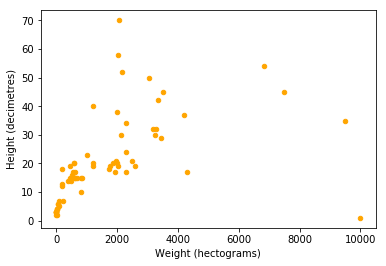

In [18]:
df[df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot.scatter('Weight', 'Height', c='orange').set(xlabel='Weight (hectograms)', ylabel='Height (decimetres)')

For this scatterplot, the first thing to note is that there is significantly less Legendary Pokémons than Non-Legendaries. Additionally, we can see that the Height and Weight for Legendaries vary extremely - with most being in the larger range.

### Combined

[Text(0, 0.5, 'Height (decimetres)'), Text(0.5, 0, 'Weight (hectograms)')]

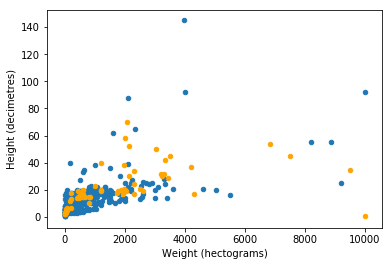

In [19]:
ax = df[~df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot('Weight', 'Height', kind='scatter')
df[df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot('Weight', 'Height', kind='scatter', c='orange', ax=ax).set(xlabel='Weight (hectograms)', ylabel='Height (decimetres)')

Combining both scatter plots shows that although Legendary Pokémons are larger in size, there are exceptions to this case. An outlier example being that there is a Non-Legendary that is the tallest out of all Pokémon. Another irrational outlier is that there is a Legendary that is short but is the heaviest Pokémon overall.

### Means of Weight and Height

Legendary mean: maroon  
Regular mean: cyan

Legendary Pokemon average weight:  1716.66 ; average height:  20.66
Regular Pokemon average weight:  516.59 ; average height:  10.79


[Text(0, 0.5, 'Height (decimetres)'), Text(0.5, 0, 'Weight (hectograms)')]

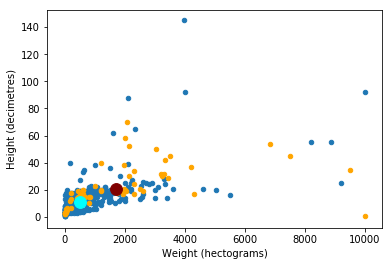

In [20]:
# legendary average height
l_h_mean = df[df['Pokemon'].isin(legend_list)]['Height'].mean()

# legendary average weight
l_w_mean = df[df['Pokemon'].isin(legend_list)]['Weight'].mean()

# regular average height
r_h_mean = df[~df['Pokemon'].isin(legend_list)]['Height'].mean()

# regular avaerage weight
r_w_mean = df[~df['Pokemon'].isin(legend_list)]['Weight'].mean()

# calculate means
df_l_mean = pd.DataFrame({"Weight":[l_w_mean], "Height":[l_h_mean]})
df_r_mean = pd.DataFrame({"Weight":[r_w_mean], "Height":[r_h_mean]})
print('Legendary Pokemon average weight: ', round(df_l_mean.loc[0]['Weight'], 2), '; average height: ', round(df_l_mean.loc[0]['Height'], 2))
print('Regular Pokemon average weight: ', round(df_r_mean.loc[0]['Weight'], 2), '; average height: ', round(df_r_mean.loc[0]['Height'], 2))

# plot
ax = df[~df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot('Weight', 'Height', kind='scatter')
df[df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot('Weight', 'Height', kind='scatter', c='orange', ax=ax)
df_l_mean.plot.scatter('Weight', 'Height', c="maroon", s=140, ax = ax)
df_r_mean.plot.scatter('Weight', 'Height', c="cyan", s=140, ax = ax).set(xlabel='Weight (hectograms)', ylabel='Height (decimetres)')


We plot the mean Height and Weight data to display the combined average Height & Weight of Legendary and Non-Legendary, individually, amongst all Pokémons. This data also includes outliers but they do not affect the data substantially, as there are many other data points we are analyzing.

Additionally from the plot above, we can conclude that the average legendary Pokémon is likely to be taller and heavier than the average non-legendary Pokémon.

## 3.2 Types

Lets identify what typings legendary Pokemon typically are. First we need to separate the legendary data from the overall dataframe

### Make a list of Pokémon Types

In [ ]:
legendsDf = df[df['Pokemon'].isin(legend_list)]

legend_types = list(legendsDf['Type 1']) + list(legendsDf['Type 2'])
types = list(df['Type 1']) + list(df['Type 2'])

legendTypeCount = pd.Series(legend_types).value_counts().append(pd.Series([0],['poison']))
regularTypeCount = pd.Series(types).value_counts()

In [ ]:
legendsDf

Kind of hard to read, so lets just get the counts instead of individual pokemon.

In [ ]:
legendTypeCount

In [ ]:
legendPlot = legendTypeCount.plot(kind='bar', title='Legendary Pokemon Typing', yticks=range(0,25,5), color="orange")
xstuff = legendPlot.set_xlabel("Typing")
ystuff = legendPlot.set_ylabel("Count")

Here we can see that psychic dominate the typings for legendary Pokemon, doubling the counts for any other type. From there it slowly declines until we get to poison, where we can see 0 Pokemon have poison typing. Surprisingly, dragon isnt the most frequent typing, which somewhat subverted our expectations but is reasonable once we thought back onto what legendary Pokemon there were.

In [ ]:
regularTypeCount

In [ ]:
normalPlot = regularTypeCount.plot(kind='bar', title='All Pokemon Typing', yticks=range(0,150,10),  color="blue")
xstuff = normalPlot.set_xlabel("Typing")
ystuff = normalPlot.set_ylabel("Count")

Now with regular pokemon, we can see that its a lot more evenly spread out. Water has a plurality of the typings but is not as dominant as psychic was for legendaries. Poison finds itself near the middle of the type distribution, suggesting that the lack of a legendary Pokemon being poison typed may be intentional rather than through sheer chance. 

In [ ]:
typeCompDf = legendTypeCount.to_frame()
typeCompDf = typeCompDf.merge(regularTypeCount.to_frame(), left_index=True, right_index=True)
typeCompDf.columns = ['Legendary','Normal']
typeCompDf=typeCompDf.reindex(columns=['Normal','Legendary'])
normFirst = regularTypeCount.to_frame()
normFirst = normFirst.merge(legendTypeCount.to_frame(), left_index = True, right_index = True)
normFirst.columns = ['Normal','Legendary']




Now lets compare the two side-by-side.

In [ ]:
typeCompDf

In [ ]:
normFirst


In [ ]:
import matplotlib.pyplot as plt
overallPlot = typeCompDf.plot(kind='bar', title ="Type Distribution")
xstuff = overallPlot.set_xlabel("Typing")
ystuff = overallPlot.set_ylabel("Count")

In [ ]:
normFirstPlot = normFirst.plot(kind='bar', title ="Type Distribution")
xstuff = normFirstPlot.set_xlabel("Typing")
ystuff = normFirstPlot.set_ylabel("Count")

Through these two graphs, we can see that there only seems to be a small correlation between the typing for all Pokemon in general, and the typing for legendary Pokemon (seen in flying, water, and psychic for both graphs). This suggests that legendary Pokemon are made without this distribution in mind, and more made to appeal to the abstract idea of legendary that most people view as dragons or psychic beings.

# Part 4: Pokémon Stats Analysis

In [ ]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 9
pd.options.display.max_columns = 10

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

Reading the CSV

In [ ]:
df_poke = pd.read_csv("statsDF.csv")
df_poke

Dropping columns that are irrelevant to this section and splitting the dataframe into two dataframes for Legendary and NonLegendary Pokemon:

In [ ]:
df_AD = df_poke.drop(columns = ["Height","Weight","Stat Total","Type 1","Type 2"])
df_LegsEnd = df_AD[df_AD["Legendary"] == True]
df_LegsDontEnd = df_AD[df_AD["Legendary"] == False]
df_LegsEnd

### Visualizing Pokemon Distribution by Stats

Now that the data is organized distinctly, let's visualize the pokemon in scatterplots with their offensive stat totals on the x-axis and their defensive stat totals on the y-axis.

In [ ]:
df_LegsEnd.plot.scatter(x="ATK Sum", y="DEF Sum", c="orange")
plt.title("Legendary Offensive vs. Defensive Stat Distribution", pad=(25))
df_LegsDontEnd.plot.scatter(x="ATK Sum", y="DEF Sum", c="b")
plt.title("NonLegendary Offensive vs. Defensive Stat Distribution", pad=(25))
plt.show()

In the two scatterplots above, we can observe the distribution of offensive and defensive stats on the Legendary and NonLegendary Pokemon separately. In the first scatterplot, we can already see that Legendary Pokemon tend to lean in the upper range for both offsensive and defensive stats, with the exception of a couple of outliers. In the second scatterplot, we can observe that the majority of the NonLegendary Pokemon cluster in a lower range than the Legendary Pokemon. 


Now let's see how the two groups look in the same scatterplot:

In [ ]:
a = df_LegsDontEnd.plot.scatter(x="ATK Sum", y="DEF Sum", c="b")
b = df_LegsEnd.plot.scatter(x="ATK Sum", y="DEF Sum", c="orange", ax = a)
plt.title("Offensive vs. Defensive Stat Distribution", pad=(25))
plt.show()

After stacking the two scatterplots together we can observe that the majority of the Legendary Pokemon (yellow) tend to have greater stats all around. Except for a few exceptions, almost all of the Legendary Pokemon data points are in the upper right quadrant of the scatterplot such that they either have great defensive stats or greater offensive stats or even both. Only a handful of the NonLegendary Pokemon data points are in the same class as the Legendary Pokemon.

However, despite that distinct difference between the two categories of Pokemon, they both seem to have populations that do not heavily skew towards either axis.


Now, to visualize their stats as a whole and comparing their distributions, let's create another data frame to handle the "Stat Total" data and drop irrelevant columns.

In [ ]:
df_total = df_poke.drop(columns = ["Height","Weight","DEF Sum","ATK Sum","Type 1","Type 2"])
df_total

Here we'll separate the data frame into two parts: Legendary and NonLegendary:

In [ ]:
df_legtotal = df_total[df_AD["Legendary"] == True]
df_legtotal

In [ ]:
df_nontotal = df_total[df_AD["Legendary"] == False]
df_nontotal

Now with the data separated, let's visualize the distributions using histograms:

In [ ]:
df_legtotal["Stat Total"].hist(bins = 25)
plt.xlabel("Stat Total")
plt.ylabel("Pokemon")
plt.title("Legendary Total Stat Distribution", pad=(25))
plt.show()

In this first histogram, we plotted the distribution of Legendary Pokemon with respect to the total sum of all their core stats. Most notably, we observe that a large number of Legendary Pokemon have stat totals of around 600 and even a significant number around 700. Furthermore, we can observe that there is an outlier data point with a stat total of around 200. Altogether, the histogram shows that Legendary Pokemon have stat totals that skews to the right of the histogram, with notably high stats.

In [ ]:
df_nontotal["Stat Total"].hist(bins = 25)
plt.xlabel("Stat Total")
plt.ylabel("Pokemon")
plt.title("NonLegendary Total Stat Distribution", pad=(25))
plt.show()

In this second histogram, we plotted the distribution of NonLegendary Pokemon with respect to the total sum of all their core stats. Here, we can observe that the distribution is not quite normal with its two peaks at roughly 300 and 500 and a fall-off on either end that do not have any extremeley explicit outliers. The distribution seems to be wide and does not skew in either direction in particular.

Now let's see how they compare together on the same histogram:

In [ ]:
a1 = df_nontotal["Stat Total"].hist(bins = 25)
b1 = df_legtotal["Stat Total"].hist(bins = 25, ax = a1)
plt.title("Total Stat Distribution", pad=(25))
plt.xlabel("Stat Total")
plt.ylabel("Pokemon")
plt.show()

In this histogram, the two categories of Pokemon are plotted together with blue representing the NonLegendary Pokemon and orange representing the Legendary Pokemon. In this histogram, the data just barely overlaps and we chose to have the Legendary population at the front because it has a smaller population and infringes less in the overlap. Here we see that the vast majority of the Legendary Pokemon distribution is significantly right skewed are almost completely to the right of the NonLegendary Pokemon distribution.

To further examine the magnitude of their difference let's get their averages amost the entire population and visualize the comparison:

In [ ]:
numNon = len(df_nontotal["Stat Total"])
numLeg = len(df_legtotal["Stat Total"])
sumNon = df_nontotal.sum(axis = 0)[3]
sumLeg = df_legtotal.sum(axis = 0)[3]
avgNon = sumNon / numNon
avgLeg = sumLeg / numLeg
print(avgNon)
print(avgLeg)

In [ ]:
sumNonA = df_LegsDontEnd.sum(axis = 0)[3]
sumNonD = df_LegsDontEnd.sum(axis = 0)[4]
sumLegA = df_LegsEnd.sum(axis = 0)[3]
sumLegD = df_LegsEnd.sum(axis = 0)[4]
avgNonA = sumNonA / numNon
avgNonD = sumNonD / numNon
avgLegA = sumLegA / numLeg
avgLegD = sumLegD / numLeg

print(avgNonA)
print(avgNonD)
print(avgLegA)
print(avgLegD)

In [ ]:
df = pd.DataFrame({'stats':['NonLegendary', 'Legendary'], 'val':[avgNon, avgLeg]})
ax = df.plot.bar(x='stats', y='val', rot=0)
plt.title("Legendary vs NonLegendary Total Stats", pad=(25))
plt.show()

We've calculated the average NonLegendary stat total to be 405 and the average Legendary stat total to be 602. For their offsensive and defensive breakdowns we have 203 and 203, and 306 and 296 respectively. As shown in the bar graph, Legendary Pokemon are found to have approximately 50% greater stats than NonLegendary Pokemon, truly earning them a "legendary" status.

Now with their average offensive and defensive stats, let's revisit the scatterplot and add in points to show where their averages lie:

In [ ]:
df_avgLeg = pd.DataFrame({"ID":["999"], "Pokemon":["Average Legendary"], "Legendary":["True"], "ATK Sum":[avgLegA], "DEF Sum":[avgLegD]})
df_avgNon = pd.DataFrame({"ID":["999"], "Pokemon":["Average NonLegendary"], "Legendary":["False"], "ATK Sum":[avgNonA], "DEF Sum":[avgNonD]})

aaa = df_LegsDontEnd.plot.scatter(x="ATK Sum", y="DEF Sum", c="b")
bbb = df_LegsEnd.plot.scatter(x="ATK Sum", y="DEF Sum", c="orange", ax = aaa)
ccc = df_avgNon.plot.scatter(x="ATK Sum", y="DEF Sum", c="cyan", s=140, ax = aaa)
ddd = df_avgLeg.plot.scatter(x="ATK Sum", y="DEF Sum", c="maroon", s=140, ax = aaa)
plt.title("Offensive vs. Defensive Stat Distribution With Average", pad=(25))
plt.show()

After adding a big cyan data point to represent the average NonLegendary Pokemon and a big maroon data point to represent the average Legendary Pokemon, we can easily see how Legendary Pokemon tend to be roughly 50% further from the origin (0,0) point in the scatterplot.


With such a well-defined difference in stats in favor of Legendary Pokemon, it's no surprise they are referred to as such and tend to be more limited and significant.